### 1. Introduction

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

In this notebook, I will apply my machine learning skills to predict credit default. Specifically, I will leverage the Kaggle's "American Express - Default Prediction" Competition data set to build a machine learning model. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information.

The objective is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.


The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


My purpose in this notebook is to separate and understand the effect of the categorical features.

I will compare the training times and prediction performances of the following models with different encoding strategies for categorical features:
HistGradientBoostingRegressor, Light Gradient Boost Classifer and XGBoost Classifer

### 2. Key Findings

- I used the HistGradientBoostingClassifier, Light Gradient Boost Classifer (LGBM) and XGBoost Classifer with one hot encoding and ordinal encoding the categorical features. I also used the HistGradientBoostingRegressor with the native categorical support.

- HistGradientBoostClassifier with native catgoerical support led to the best balanced-accuracy.

- XGBoost with ordinal encoding was the fastest to fit and HistGradientBoostingClassifier with one hot encoding was the slowest to fit.

- The competition metric is an average of a normalized gini index and a default rate captured at 4%. My best result for categorical features modelling for the normalized gin index is 0.75 and for the default rate at 4% is 0.31. This gave me a value of 0.53 for the compeititon metric. 

### 3. Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import gc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 4. Load Train Data

In [47]:
train_data = pd.read_feather('../input/amexfeather/train_data.ftr')
print(f"number of rows in the training data: {len(train_data)}")
print(f"number of unique customer IDs: {train_data.customer_ID.nunique()}")

number of rows in the training data: 5531451
number of unique customer IDs: 458913


Customer IDs are not unique in the training data. There aer several statements per customer. Below I count here how many credit card statements there are per customer. We see 386034 most customers have 13 statements and the rest have less than 13. This can cause an issue for modelling, because the model needs to handle a varianle input length. To make things simpler, I will remove the customers will less than 13 statements for my modelling.

In [3]:
train_data.customer_ID.value_counts().value_counts().sort_index(ascending=False)

count
13    386034
12     10623
11      5961
10      6721
9       6411
8       6110
7       5198
6       5515
5       4671
4       4673
3       5778
2       6098
1       5120
Name: count, dtype: int64

In [48]:
train_data = train_data.groupby('customer_ID').tail(1).set_index('customer_ID')

The following features are categorical as per the competition Dataset description:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

I will select the categorical columns and put them in X for model training.

In [49]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

X = train_data[categorical_columns]
y = train_data['target']

X.loc[:,categorical_columns] = X[categorical_columns].astype("category")

n_categorical_features = len(X.select_dtypes(include="category").columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 458913
Number of features: 11
Number of categorical features: 11
Number of numerical features: 0


### 5. Competition Metric

The evaluation metric, 𝑀, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, 𝐺, and default rate captured at 4%, 𝐷.

𝑀=0.5⋅(𝐺+𝐷)

The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.

For both of the sub-metrics 𝐺 and 𝐷, the negative labels are given a weight of 20 to adjust for downsampling.

This metric has a maximum value of 1.0.

This is the code for calculating this metric, provided by the competition.


In [5]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename('prediction')
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

### 6. Model Training and Cross-Validation

### 6.1. Categorical Features Encoding

Here I create a column transformer that will one-hot encode the categorical features. 

One hot encoding is a process used to convert categorical data into a format that can be provided to machine learning algorithms to improve their performance. It is particularly useful when working with categorical data that doesn't have an inherent ordinal relationship. One hot encoding is a binary representation of categorical data, where each category is represented as a binary vector. One-hot encoding can be slow if there are many features or if each feature has many categories. My goal is to experiment with differenet encodings and comapare performance and fit.


In [6]:
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ))

Next, I create a column transformer that will treat categorical features as if they were ordered quantities, i.e. the categories will be encoded as 0, 1, 2, etc.

Ordinal encoding is a data transformation technique used for categorical data where the categories have an inherent ordinal relationship. In contrast to one hot encoding, which creates binary vectors for each category, ordinal encoding assigns a unique integer to each category based on its order or rank.

In [7]:
ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    verbose_feature_names_out=False,
)

### 6.2 HistGradientBoostingClassifier

I will use the Histogram-based Gradient Boosting Classification Tree for modelling the categorical features. 

HistGradientBoostingClassifier is a type of gradient boosting algorithm introduced in scikit-learn, a popular machine learning library in Python. It is an implementation of histogram-based gradient boosting, which is an optimized version of the traditional gradient boosting algorithm. This classifier is efficient for both binary and multiclass classification tasks. This is a faster variant of GradientBoostingClassifier for big datasets.

When using the HistGradientBoostingClassifier with categorical features, you should ensure that the categorical features are appropriately encoded or represented in a format that the classifier can understand. The classifier will automatically handle the processing of categorical features during the training and prediction stages.

HistGradientBoostingClassifier can handle categorical features directly without the need for one hot encoding or other preprocessing steps (native categorical support). To use this feature, I need to set categorical_features=categorical_columns. This capability makes it a powerful tool for handling a wide variety of datasets, especially those that contain a mix of categorical and numerical data.


I will compare the performance using one-hot encoding, ordinal encoding and the native categorical support of the estimator.

I will make three piplelines for HistGradientBoostingClassifier. hist_one_Hot uses the one-hot encoding. hist_ordinal ues the ordinal encoding, but treats the features as continuous variables. The hist_native uses ordinal encoding as well, but this pipeline will natively handle the categorial features.

The main difference between this pipeline and the hist_ordinal is that in hist_native, I let the HistGradientBoostingRegressor know which features are categorical.

In [27]:
hist_one_hot = make_pipeline(one_hot_encoder, HistGradientBoostingClassifier(random_state=42))
hist_ordinal = make_pipeline(ordinal_encoder, HistGradientBoostingClassifier(random_state=42))
hist_native = make_pipeline(ordinal_encoder,HistGradientBoostingClassifier(random_state=42,categorical_features=categorical_columns)).set_output(transform="pandas")

### ROC Curve and AUC

Here I will use StratifiedKFold with 10 splits to train the HistGradientBoostClassifier model and evaluate the competition metric and AUC for each fold.

AUC, or Area Under the Curve, is a metric commonly used to evaluate the performance of a classification model, particularly in binary classification tasks. It represents the area under the receiver operating characteristic (ROC) curve, which is a graphical representation of the true positive rate (sensitivity) plotted against the false positive rate (1 - specificity) at various thresholds. AUC is a popular metric for evaluating the overall performance of a classification model, especially when the class distribution is imbalanced like our dataset. It provides a single value that summarizes the model's ability to discriminate between the classes across all possible classification thresholds.

AUC ranges from 0 to 1, where a model with perfect discrimination has an AUC value of 1, while a model with no discrimination or a completely random classifier has an AUC of 0.5. The higher the AUC value, the better the model's ability to distinguish between the positive and negative classes.

In [39]:
hist_val_probs, M, y_valid = [], [], []
model = hist_native

sk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):

    print("\nFold {}".format(fold + 1))
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}\n".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

    model.fit(X_train, y_train) 
    y_valid.append(y_val)

    y_pred = model.predict_proba(X_val)[:, 1]
    hist_val_probs.append(y_pred)

    y_pred = pd.Series(y_pred, name='prediction')
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score = amex_metric(y_true=y_true, y_pred=y_pred)
    M.append(M_score)

    auc_score = roc_auc_score(y_val, y_pred)
    print("Validation Metric: {:.5f}, AUC: {:.4f}".format(M_score, auc_score))

    del X_train, y_train, X_val, y_val
    _ = gc.collect()


Fold 1
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.53191, AUC: 0.8746

Fold 2
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.53320, AUC: 0.8755

Fold 3
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.52913, AUC: 0.8745

Fold 4
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53046, AUC: 0.8764

Fold 5
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.51958, AUC: 0.8715

Fold 6
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.52969, AUC: 0.8743

Fold 7
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53297, AUC: 0.8767

Fold 8
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53330, AUC: 0.8771

Fold 9
Train shape: (41

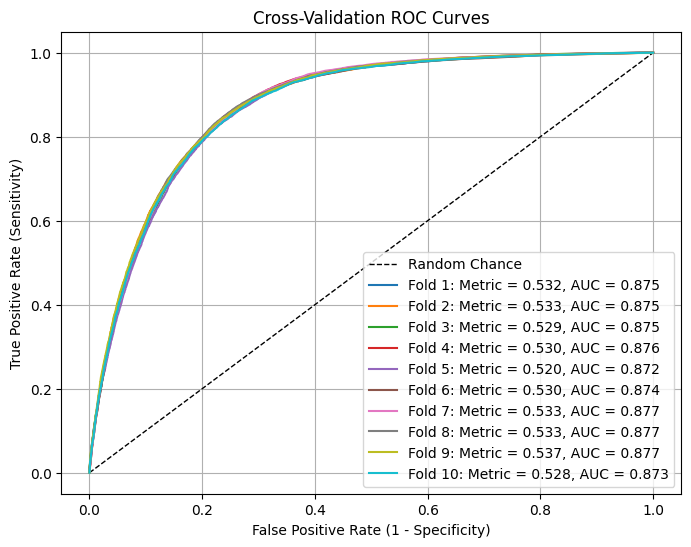

In [40]:
def plot_roc(y_val, y_prob, M):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1, label='Random Chance')

    for i in range(len(y_val)):
        y = y_val[i]
        prob = y_prob[i]
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Fold {}: Metric = {:.3f}, AUC = {:.3f}'.format(i + 1, M[i], roc_auc))

    plt.title("Cross-Validation ROC Curves")
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc(y_valid, hist_val_probs, M)

### Insight:

We see that AUC is around 0.88 for each fold, which is not bad. Th evaluated competition metric is about 0.53, which is low. I suspect it is the default rate at 4% that is brining down the competition metric value. I will explore this later in the notebook. 

### 6.3. LightGBM Classifier

LightGBM, short for light gradient-boosting machine, is a free and open-source distributed gradient-boosting framework for machine learning, originally developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks.

LightGBM (Light Gradient Boosting Machine) is a powerful and efficient gradient boosting framework developed by Microsoft. It is based on decision tree algorithms and used for ranking, classification and other machine learning tasks. It is designed for distributed and efficient training of large-scale datasets. LightGBM is known for its speed, scalability, and high performance.

I will use RandomizedSearchCV to find the optimal hyperparamters for lightGBM. I will train LGBM with ordinal encoded and one-hot encoded categorical features and will compare performance and fit for this model.



### Hyperparameter Tuning

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm_ordinal = make_pipeline(ordinal_encoder, lgb.LGBMClassifier(boosting_type='gbdt',random_state=42))
model = lgbm_ordinal['lgbmclassifier']

param_random_gb = {'learning_rate': np.arange(0.05,0.55, 0.1), 'n_estimators' : [125,150,175], 'subsample' : np.arange(0.3,1.0, 0.1), 'max_depth':[3,4,5]}
mse_random = RandomizedSearchCV(model, param_distributions = param_random_gb, n_iter = 10, scoring = 'balanced_accuracy', cv = 4, verbose = 1)
mse_random.fit(X_train, y_train)

print("Best parameter: ", mse_random.best_params_)'''

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameter:  {'subsample': 0.8000000000000003, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.25000000000000006}


Best parameters found was : {'subsample': 0.8000000000000003, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.25000000000000006}

Now I will define two pipelines with the optimal LGBM hyperparameters, one with the one-hot-encoder and one with the ordinal-encoder.

In [41]:
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=150, learning_rate=0.25,  max_depth=4,   random_state=42)

lgbm_one_hot = make_pipeline(one_hot_encoder, lgbm)
lgbm_ordinal = make_pipeline(ordinal_encoder, lgbm)

### ROC Curve and AUC
I will use StratifiedKFold with 10 splits to train the LGBM model and evaluate the competition metric and AUC for each fold.

I am going to use one hot encoded categorical features for this evaluation.

In [53]:
gbm_val_probs, M, y_valid = [], [], []
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=150, learning_rate=0.25, max_depth=4, random_state=42)

lgbm_one_hot = make_pipeline(one_hot_encoder, lgbm)
ft_importance = pd.DataFrame(index=X.columns)

model = lgbm_one_hot['lgbmclassifier']

sk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):

    print("\nFold {}".format(fold + 1))
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}\n".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],eval_metric=['auc', 'binary_logloss']) 
    y_valid.append(y_val)

    y_pred = model.predict_proba(X_val)[:, 1]
    gbm_val_probs.append(y_pred)

    y_pred = pd.Series(y_pred, name='prediction')
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score = amex_metric(y_true=y_true, y_pred=y_pred)
    M.append(M_score)

    auc_score = roc_auc_score(y_val, y_pred)
    ft_importance["Importance_Fold" + str(fold)] = model.feature_importances_
    print("Validation Metric: {:.5f}, AUC: {:.4f}".format(M_score, auc_score))

    del X_train, y_train, X_val, y_val
    _ = gc.collect()



Fold 1
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.53575, AUC: 0.8755

Fold 2
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.53288, AUC: 0.8758

Fold 3
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.52705, AUC: 0.8751

Fold 4
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53216, AUC: 0.8771

Fold 5
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.52263, AUC: 0.8725

Fold 6
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.52933, AUC: 0.8749

Fold 7
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53291, AUC: 0.8775

Fold 8
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53340, AUC: 0.8780

Fold 9
Train shape: (41

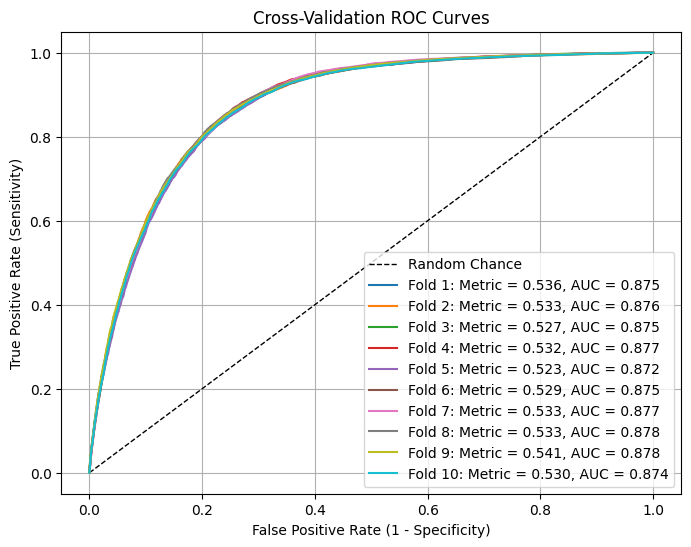

In [54]:
plot_roc(y_valid, gbm_val_probs, M)

The above plot shows the ROC Curve. The ROC (Receiver Operating Characteristic) curve is a graphical plot that illustrates the performance of a binary classification model at various classification thresholds. It displays the relationship between the true positive rate (sensitivity) and the false positive rate (1 - specificity) as the discrimination threshold is varied.


### Insight:

It is interesting that AUC and the competition evaluation metric is close to the previous model.

### 6.4. XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of the gradient boosting algorithm, which is widely used for supervised learning tasks. It is popular for its speed, performance, and ability to handle complex structured data. XGBoost is based on the gradient boosting framework, which builds an ensemble of weak learners (typically decision trees) to create a strong predictive model

XGBoost is designed to optimize performance and computational speed. It has become a standard algorithm for winning machine learning competitions and is widely used in various industry applications.

XGBoost can handle missing values internally during the training process. This is important, because we have many missing values in our dataset.

XGBoost supports built-in cross-validation, enabling users to estimate the performance of the model and tune hyperparameters effectively.

I will use RandomizedSearchCV to find the optimum hyperparameters for my model.

### Hyperparameter Tuning

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic',tree_method='gpu_hist',predictor='gpu_predictor',random_state=42, enable_categorical= True)
xgb_ordinal = make_pipeline(ordinal_encoder, xgb_clf)
model = xgb_ordinal['xgblassifier']

param_random_gb = {'learning_rate': np.arange(0.05,0.55, 0.1), 'n_estimators' : [125,150,175], 'subsample' : np.arange(0.3,1.0, 0.1), 'max_depth':[3,4,5]}
mse_random = RandomizedSearchCV(model, param_distributions = param_random_gb, n_iter = 10, scoring = 'balanced_accuracy', cv = 4, verbose = 1)
mse_random.fit(X_train, y_train)

print("Best parameter: ", mse_random.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameter:  {'subsample': 0.9000000000000001, 'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.35000000000000003}


The result of the tuning is the following hyperparameters: 

{'subsample': 0.9000000000000001, 'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.35000000000000003}

I will define two pipelines for the one-hot encoding and the ordinal encoding. I will evaluate and compare the model performance and fit for the two types of encodings.

### ROC Curve and AUC

In [50]:
xgb_parms = { 
    'max_depth':3,
    'gamma': 0.5,
    'learning_rate':0.35, 
    'subsample':0.9,
    'eval_metric':'auc',
    'colsample_bytree':0.6, 
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':42,
    'n_estimators':125
    ,'enable_categorical': True
}
xgb_clf = xgb.XGBClassifier(**xgb_parms)

xgb_one_hot = make_pipeline(one_hot_encoder, xgb_clf)
xgb_ordinal = make_pipeline(ordinal_encoder, xgb_clf)

I am going to use ordinal encoded categorical features for this evaluation.

In [51]:
xgb_val_probs, M, y_valid = [], [], []

ft_importance = pd.DataFrame(index=X.columns)
model = xgb_ordinal['xgbclassifier'] 

sk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(sk_fold.split(X, y)):

    print("\nFold {}".format(fold + 1))
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_val, y_val = X.iloc[val_idx, :], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}\n".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False) 
    y_valid.append(y_val)

    y_pred = model.predict_proba(X_val)[:, 1]
    xgb_val_probs.append(y_pred)

    y_pred = pd.Series(y_pred, name='prediction')
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score = amex_metric(y_true=y_true, y_pred=y_pred)
    M.append(M_score)

    auc_score = roc_auc_score(y_val, y_pred)
    ft_importance["Importance_Fold" + str(fold)] = model.feature_importances_
    print("Validation Metric: {:.5f}, AUC: {:.4f}".format(M_score, auc_score))

    del X_train, y_train, X_val, y_val
    _ = gc.collect()



Fold 1
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.53525, AUC: 0.8753

Fold 2
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.53430, AUC: 0.8758

Fold 3
Train shape: (413021, 11), (413021,), Valid shape: (45892, 11), (45892,)

Validation Metric: 0.52982, AUC: 0.8751

Fold 4
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53249, AUC: 0.8768

Fold 5
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.52058, AUC: 0.8723

Fold 6
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.52886, AUC: 0.8748

Fold 7
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53326, AUC: 0.8774

Fold 8
Train shape: (413022, 11), (413022,), Valid shape: (45891, 11), (45891,)

Validation Metric: 0.53344, AUC: 0.8778

Fold 9
Train shape: (41

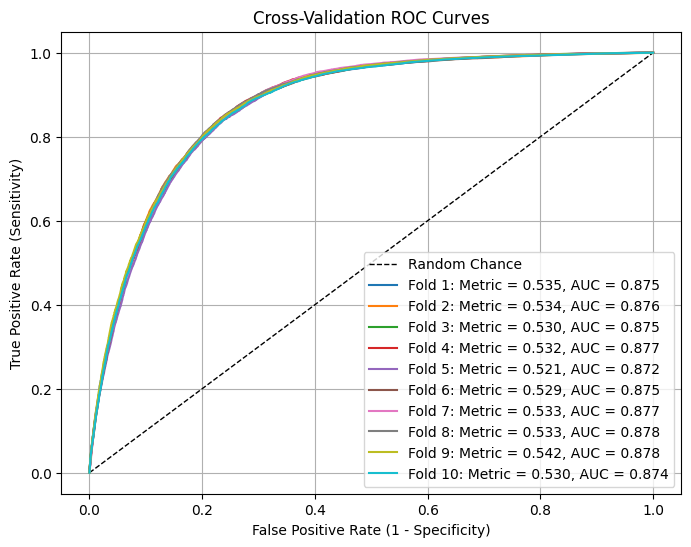

In [52]:
plot_roc(y_valid, xgb_val_probs, M)

### Insight:

Again I see that AUC and competition metric are close in value to the two other values evaluated earlier.

### 6.5. Model Comparison (Balanced Accuracy)

I evaluate the models using cross validation. I use the balanced_accuracy for scoring.

Balanced accuracy is a metric used to evaluate the performance of a classification model, especially when the classes are imbalanced. It is the arithmetic mean of the sensitivity (true positive rate) and specificity (true negative rate), calculated for each class. The balanced accuracy gives an unbiased estimate of the model's ability to correctly classify both the majority and minority classes.

Balanced accuracy provides a more reliable evaluation metric than accuracy when dealing with imbalanced datasets, where the class distribution is skewed. This is the case here, because in this dataset, 26% of customers have defaulted. By considering both sensitivity and specificity, it offers a comprehensive assessment of a classifier's performance on both the positive and negative classes. A value of 1 indicates perfect performance, while a value of 0 indicates the worst possible performance.

I will compare the models performance in terms of balanced_accuracy and fit times.

In [19]:
n_cv_folds = 3
scoring = "balanced_accuracy"

one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)
lgbm_one_hot_result = cross_validate(lgbm_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
lgbm_ordinal_result = cross_validate(lgbm_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
xgb_one_hot_result = cross_validate(xgb_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
xgb_ordinal_result = cross_validate(xgb_ordinal, X, y, cv=n_cv_folds, scoring=scoring)

In [15]:
def plot_results(figure_title, test_score_y_limit, items, labels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Balanced Accuracy", ax2, test_score_y_limit),
    ]

    n = len(items)
    x, width = np.arange(n), 0.9
    for key, title, ax, y_limit in plot_info:
        mape_cv_mean = [np.mean(np.abs(item[key])) for item in items]
        mape_cv_std = [np.std(item[key]) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=[f"C{i}" for i in range(n)],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=labels,
            ylim=y_limit,
        )
    fig.suptitle(figure_title)

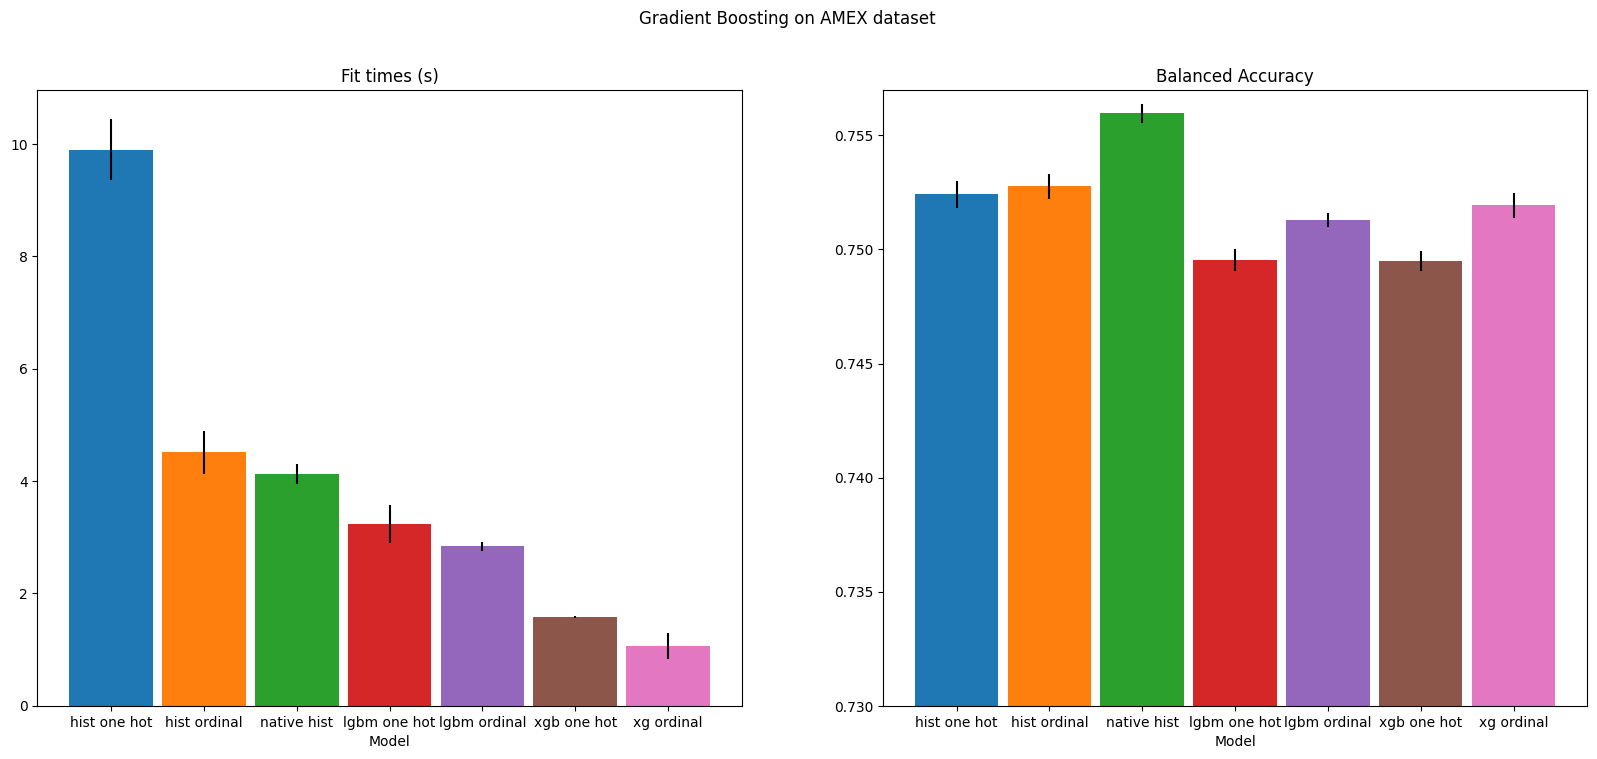

In [21]:
plot_results("Gradient Boosted Tree Models on AMEX Dataset (Categorical Features)", [0.73, 0.757], [one_hot_result, ordinal_result, native_result, lgbm_one_hot_result, lgbm_ordinal_result, xgb_one_hot_result, xgb_ordinal_result], ['hist one hot', 'hist ordinal', 'native hist', 'lgbm one hot', 'lgbm ordinal', 'xgb one hot', 'xg ordinal'])

### Insights:

The HistGradientBoost model with one-hot-encoded data is by far the slowest. This is to be expected, since one-hot-encoding creates one additional feature per category value (for each categorical feature), and thus more split points need to be considered during fitting.

Interms of balanced_accuarcy, the native handling has the best performance. So that is the model I will use for evaluating the competition metric.

### 7. Normalized Gini Index v. Default Rate

Let's evaluate the competition metric with my best model, which is the HistGradientBoostClassifier with native categorical support.

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

y_valid, M=[],[]
model = hist_native

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]

    y_pred = pd.Series(y_pred).rename('prediction', inplace=True)
    y_true = y_val.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    M_score=amex_metric(y_true = y_true, y_pred = y_pred)
    
    M.append(M_score)
    y_valid.append(y_val)

M

[0.5316962316784404, 0.5252451155618706, 0.5320995356184438]

In [29]:
print(f"Competition evaluation score: {np.mean(M)}")

Competition evaluation score: 0.5296802942862516


The score is 0.53, which is quite low. Let's explore why.

The evaluation metric, 𝑀, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, 𝐺, and default rate captured at 4%, 𝐷.

𝑀=0.5⋅(𝐺+𝐷)

The weighted Gini index is a measure of the statistical dispersion of predicted scores in a binary classification problem, and it assigns different weights to different instances based on their true labels. It is a variation of the traditional Gini index used in decision trees and is commonly used in credit scoring and risk modeling.

The top_four_percent_captured calculates the percentage of positive instances (target=1) captured among the top four percent of instances based on their predicted scores. It assigns a higher weight (20) to instances with a target value of 0.

amex_metric combines the two sub-metrics: the normalized weighted Gini and the top four percent captured. It returns a weighted combination of these metrics, with equal weight (0.5) given to each.


In [30]:
def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    df = (pd.concat([y_true, y_pred], axis='columns').sort_values('prediction', ascending=False))
    df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
    four_pct_cutoff = int(0.04 * df['weight'].sum())
    df['weight_cumsum'] = df['weight'].cumsum()
    df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
    return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    df = (pd.concat([y_true, y_pred], axis='columns').sort_values('prediction', ascending=False))
    df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
    df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
    total_pos = (df['target'] * df['weight']).sum()
    df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
    df['lorentz'] = df['cum_pos_found'] / total_pos
    df['gini'] = (df['lorentz'] - df['random']) * df['weight']
    return df['gini'].sum()

def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    y_true_pred = y_true.rename('prediction')
    return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

In [31]:
hist_one_hot = make_pipeline(one_hot_encoder, HistGradientBoostingClassifier(random_state=42))
hist_ordinal = make_pipeline(ordinal_encoder, HistGradientBoostingClassifier(random_state=42))
hist_native = make_pipeline(ordinal_encoder,HistGradientBoostingClassifier(random_state=42,categorical_features=categorical_columns,),).set_output(transform="pandas")
n_cv_folds = 3
scoring = 'balanced_accuracy'

one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)
lgbm_one_hot_result = cross_validate(lgbm_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
lgbm_ordinal_result = cross_validate(lgbm_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
xgb_one_hot_result = cross_validate(xgb_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
xgb_ordinal_result = cross_validate(xgb_ordinal, X, y, cv=n_cv_folds, scoring=scoring)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

hist_one_hot.fit(X_train, y_train)
y_pred_hist_one_hot = hist_one_hot.predict_proba(X_val)[:,1]
y_pred_hist_one_hot = pd.Series(y_pred_hist_one_hot).rename('prediction', inplace=True)
y_pred_hist_one_hot = y_pred_hist_one_hot.reset_index(drop=True)

hist_ordinal.fit(X_train, y_train)
y_pred_hist_ordinal = hist_ordinal.predict_proba(X_val)[:,1]
y_pred_hist_ordinal = pd.Series(y_pred_hist_ordinal).rename('prediction', inplace=True)
y_pred_hist_ordinal = y_pred_hist_ordinal.reset_index(drop=True)

hist_native.fit(X_train, y_train)
y_pred_hist_native = hist_native.predict_proba(X_val)[:,1]
y_pred_hist_native = pd.Series(y_pred_hist_native).rename('prediction', inplace=True)
y_pred_hist_native = y_pred_hist_native.reset_index(drop=True)

lgbm_one_hot.fit(X_train, y_train)
y_pred_lgbm_one_hot = lgbm_one_hot.predict_proba(X_val)[:,1]
y_pred_lgbm_one_hot = pd.Series(y_pred_lgbm_one_hot).rename('prediction', inplace=True)
y_pred_lgbm_one_hot = y_pred_lgbm_one_hot.reset_index(drop=True)

lgbm_ordinal.fit(X_train, y_train)
y_pred_lgbm_ordinal = lgbm_ordinal.predict_proba(X_val)[:,1]
y_pred_lgbm_ordinal = pd.Series(y_pred_lgbm_ordinal).rename('prediction', inplace=True)
y_pred_lgbm_ordinal = y_pred_lgbm_ordinal.reset_index(drop=True)

xgb_one_hot.fit(X_train, y_train)
y_pred_xgb_one_hot = xgb_one_hot.predict_proba(X_val)[:,1]
y_pred_xgb_one_hot = pd.Series(y_pred_xgb_one_hot).rename('prediction', inplace=True)
y_pred_xgb_one_hot = y_pred_xgb_one_hot.reset_index(drop=True)

xgb_ordinal.fit(X_train, y_train)
y_pred_xgb_ordinal = xgb_ordinal.predict_proba(X_val)[:,1]
y_pred_xgb_ordinal = pd.Series(y_pred_xgb_ordinal).rename('prediction', inplace=True)
y_pred_xgb_ordinal = y_pred_xgb_ordinal.reset_index(drop=True)

y_true = y_val.reset_index(drop=True)

g_hist_one_hot = normalized_weighted_gini(y_true, y_pred_hist_one_hot)
g_hist_ordinal = normalized_weighted_gini(y_true, y_pred_hist_ordinal)
g_hist_native = normalized_weighted_gini(y_true, y_pred_hist_native)
g_lgbm_one_hot = normalized_weighted_gini(y_true, y_pred_lgbm_one_hot)
g_lgbm_ordinal = normalized_weighted_gini(y_true, y_pred_lgbm_ordinal)
g_xgb_one_hot = normalized_weighted_gini(y_true, y_pred_xgb_one_hot)
g_xgb_ordinal = normalized_weighted_gini(y_true, y_pred_xgb_ordinal)

d_hist_one_hot = top_four_percent_captured(y_true, y_pred_hist_one_hot)
d_hist_ordinal = top_four_percent_captured(y_true, y_pred_hist_ordinal)
d_hist_native = top_four_percent_captured(y_true, y_pred_hist_native)
d_lgbm_one_hot = top_four_percent_captured(y_true, y_pred_lgbm_one_hot)
d_lgbm_ordinal = top_four_percent_captured(y_true, y_pred_lgbm_ordinal)
d_xgb_one_hot = top_four_percent_captured(y_true, y_pred_xgb_one_hot)
d_xgb_ordinal = top_four_percent_captured(y_true, y_pred_xgb_ordinal)

print(f"HistGradientBoostClassifier with one hot encoding: normalized weighted gini: {g_hist_one_hot}, 4% default rate captured: {d_hist_one_hot}, Competition Metric: {0.5 * (g_hist_one_hot + d_hist_one_hot)}")
print(f"HistGradientBoostClassifier with ordinal encoding: normalized weighted gini: {g_hist_ordinal}, 4% default rate captured: {d_hist_ordinal}, Competition Metric: {0.5 * (g_hist_ordinal + d_hist_ordinal)}")
print(f"HistGradientBoostClassifier with native categorical support: normalized weighted gini: {g_hist_native}, 4% default rate captured: {d_hist_native}, Competition Metric: {0.5 * (g_hist_native + d_hist_native)}")
print(f"LGBM with one hot encoding: normalized weighted gini: {g_lgbm_one_hot}, 4% default rate captured: {d_lgbm_one_hot}, Competition Metric: {0.5 * (g_lgbm_one_hot + d_lgbm_one_hot)}")
print(f"LGBM wwith ordinal encoding: normalized weighted gini: {g_lgbm_ordinal}, 4% default rate captured: {d_lgbm_ordinal}, Competition Metric: {0.5 * (g_lgbm_ordinal + d_lgbm_ordinal)}")
print(f"XGBoost with one hot encoding: normalized weighted gini: {g_xgb_one_hot}, 4% default rate captured: {d_xgb_one_hot}, Competition Metric: {0.5 * (g_xgb_one_hot + d_xgb_one_hot)}")
print(f"XGBoost with ordinal encoding: normalized weighted gini: {g_xgb_ordinal}, 4% default rate captured: {d_xgb_ordinal}, Competition Metric: {0.5 * (g_xgb_ordinal + d_xgb_ordinal)}")

HistGradientBoostClassifier with one hot encoding: normalized weighted gini: 0.7467578495807017, 4% default rate captured: 0.31002301201738686, Competition Metric: 0.5283904307990442
HistGradientBoostClassifier with ordinal encoding: normalized weighted gini: 0.7470962241118216, 4% default rate captured: 0.30557402198926104, Competition Metric: 0.5263351230505413
HistGradientBoostClassifier with native categorical support: normalized weighted gini: 0.746122866238185, 4% default rate captured: 0.305241626182562, Competition Metric: 0.5256822462103735
LGBM with one hot encoding: normalized weighted gini: 0.7471370825342878, 4% default rate captured: 0.30565072871388393, Competition Metric: 0.5263939056240858
LGBM wwith ordinal encoding: normalized weighted gini: 0.7472044433235504, 4% default rate captured: 0.30554845308105344, Competition Metric: 0.5263764482023019
XGBoost with one hot encoding: normalized weighted gini: 0.7465401346587498, 4% default rate captured: 0.3030171311684991, 

In [33]:
default_rates = [d_hist_one_hot, d_hist_ordinal, d_hist_native, d_lgbm_one_hot, d_lgbm_ordinal, d_xgb_one_hot, d_xgb_ordinal]
normalized_weighted_gini = [g_hist_one_hot, g_hist_ordinal, g_hist_native, g_lgbm_one_hot, g_lgbm_ordinal, g_xgb_one_hot, g_xgb_ordinal]
sorted_default_rate=[x for y, x in sorted(zip(normalized_weighted_gini, default_rates))]
sorted_normalized_weighted_gini=[y for y, x in sorted(zip(normalized_weighted_gini, default_rates))]

Text(0, 0.5, 'normalized weighted gini')

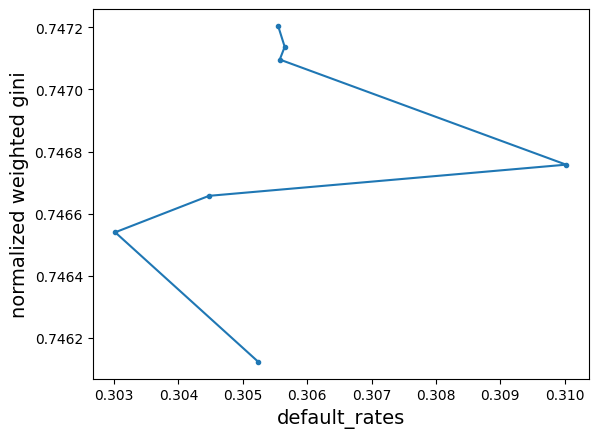

In [35]:
plt.plot(sorted_default_rate, sorted_normalized_weighted_gini, '.-')
plt.xlabel('default_rates', fontsize=14)
plt.ylabel('normalized weighted gini', fontsize=14)

### Insights:



- The 4% default rate and the normalized gini index are close in value for all the models I used.

- The 4% default rate is very low (0.3) for all the models and that is what is brining the avergae down for the competition metric.

- As a next step, it would be interestng to explore other methods to train for categorical features to see if I can improve the score. Since the 4% default rate is based on ranking the values, it would be useful to use a ranking model for training. Another idea would be to experiment with different thresholds for classification and to see if that leads to better results.